# Aufgabe 29 - Entfaltung mit quadratischen Matrizen

## Teilaufgabe a)
DIe Matrix beschreibt einen Messprozess, in welchem die Daten $n$ verschiedenen Bins zugeordnet werden können und Fehlklassifikation nur zu nächsten Nachbarn hin stattfinden können. Dies geschieht mit Wahrscheinlichkeit $\epsilon$.

In [1]:
import numpy as np
from scipy.sparse import diags # to easily make a tridiagonal matrix
import matplotlib.pyplot as plt

In [2]:
def getResponseMatrix(n, epsilon):
    A = 1-2*epsilon*np.ones(n)
    A[0] = A[n-1] = 1-epsilon
    diagonals = [A, epsilon*np.ones(n-1), epsilon*np.ones(n-1)]
    A = diags(diagonals, [0, 1, -1]).toarray() # 0,1,-1 means place the subarrays of diagonals
    # in the main diag and the two sub diags
    return A

## Teilaufgabe b)

In [3]:
n = 20
epsilon = 0.23
A = getResponseMatrix(n, epsilon)
f = np.array([193,485,664,763,804,805,779,736,684,626,
              566,508,452,400,351,308,268,233,202,173])
g = np.dot(A,f)
prng = np.random.RandomState(0) # Das ist zur Reproduzierbarkeit!
gmess = prng.poisson(g, np.size(g)) # Ziehe np.size(g) poissonverteilte Zufallszahlen mit lambda=g
print('Die gemessenen g sind bei uns dann',gmess)

Die gemessenen g sind bei uns dann [262 465 640 745 873 825 780 684 705 623 534 510 438 398 358 346 262 243
 209 167]


## Teilaufgabe c)
Die Faltungsgleichung $\mathbf{g} = \mathbf{A} \, \mathbf{f}$ lautet mit $\mathbf{A} = \mathbf{U} \, \mathbf{D} \, \mathbf{U}^{-1}$ dann
\begin{equation}
    \mathbf{g} = \mathbf{U} \, \mathbf{D} \, \mathbf{U}^{-1} \mathbf{f} \iff \mathbf{c} = \mathbf{D} \mathbf{b}
\end{equation}
mit $\mathbf{c} = \mathbf{U}^{-1} \mathbf{g}$ und $\mathbf{b} = \mathbf{U}^{-1} \mathbf{f}$.

In [4]:
w, U = np.linalg.eig(A) # w are the eigenvalues, U is a matrix of eigenvectors
index = w.argsort()[::-1]
w = w[index]
U = U[:,index]
Uinv = np.linalg.inv(U)
D = np.diag(w)
Dinv = np.linalg.inv(D)
# Nun sind die EW sortiert und die EV in der Matrix U auch.

## Teilaufgabe d)

Die skallierten b-Koeffizienten:
[1.00334441e+02 3.30824719e+01 2.13587947e+01 1.47951863e+01
 1.34159638e+01 6.93166755e+00 5.86135512e+00 2.58205025e+00
 5.31173575e-01 6.92396831e-02 8.27233394e-01 1.64986702e+00
 2.78441228e+00 1.54867656e-01 3.34870305e-01 7.70451475e-01
 8.24084378e-01 1.22894171e-01 2.02972391e+00 4.44515160e-01]


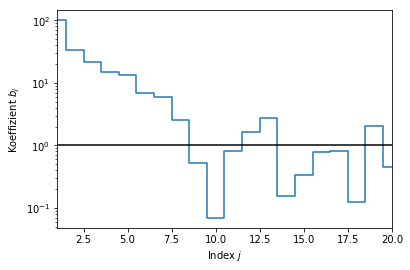

In [5]:
c = Uinv@gmess #Transformation in EV-Basis
b = Dinv@c #Transformation in EV-Basis

Vg = np.diag(gmess) #Kovarianzmatrix von gmess, Poissonverteilung: Varianz=Erwartungswert
B = Dinv@Uinv 
Vb = B@Vg@B.T ##Kovarianzmatrix von b, transformiert mit BVB-Formel
bvar = np.diag(Vb)
bstan = np.sqrt(bvar)
bskal = np.abs(b/bstan) # auf ihre Standardabweichungen skalierte b-Koeffizienten
print('Die skallierten b-Koeffizienten:')
print(bskal)

plt.yscale('log')
plt.step(np.linspace(1,np.size(bskal),np.size(bskal)), bskal, where='mid')
plt.plot([1,20],[1,1], 'k')
plt.xlim(1,20)
plt.xlabel(r'Index $j$')
plt.ylabel(r'Koeffizient $b_j$')
plt.show()

Koeffizienten, die unterhalb der 1 liegen, sind kleiner als ihre eigene Standardabweichung.
Deshalb bieten diese Werte keine nützliche Information und sollten nicht berücksichtigt werden.


## Teilaufgabe e)

In [27]:
#In der folgenden Schleife wird ein Vektor mit regularisierten b-Koeffizienten erstellt.
# Wird das erste Mal ein skallierter b-Koeffizient kleiner als eins erreicht werden alle folgenden auf 0 gesetzt.

breg = np.array(b)
bvar_reg = np.array(bvar) # auch die Varianz von b muss reguliert werden.

k = 0
cut = False
for i in bskal:
    if cut:
        breg[k] = 0
        bvar_reg[k] = 0
    else:
        if i < 1:
            cut = True
    
    k +=1
    
print(b)
print(breg)
print(bvar)
print(bvar_reg)

[-2251.04963295  -690.91922954  -466.52623091  -342.23670464
  -329.3666805   -179.20573364  -160.66734023   -77.26719097
    17.4191047      2.55736399    34.36919299   -78.49226697
  -157.473201      10.5043462    -28.13801846    80.73244377
   110.35416432   -21.61573022   464.69860952   124.47914325]
[-2251.04963295  -690.91922954  -466.52623091  -342.23670464
  -329.3666805   -179.20573364  -160.66734023   -77.26719097
    17.4191047      0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.        ]
[  503.35         436.17287643   477.08817451   535.07208506
   602.71995834   668.38754778   751.3791491    895.49026143
  1075.42155159  1364.19026798  1726.1659808   2263.37158939
  3198.49907262  4600.62253089  7060.47216831 10980.08280299
 17932.22132326 30936.93290996 52416.59533933 78418.77002851]
[ 503.35        436.17287643  477.08817451  535.07208506  602.71995834
  668.38754778  751.3791491

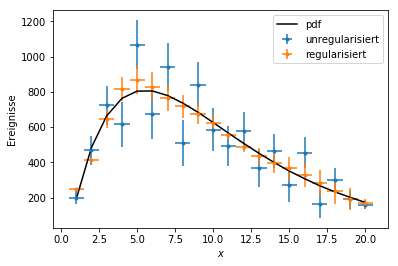

In [31]:
#Rüchtransformation in alte Basis
funreg = U@b 
freg = U@breg 

# Standardabweichung von rücktransformierten f mit BVB-Formel
funreg_stan = np.sqrt(np.diag(U@Vb@U.T))
Vbreg = Vb-np.diag(bvar)+np.diag(bvar_reg) #regularisierte Kovarianzmatrix
freg_stan = np.sqrt(np.abs((np.diag(U@Vbreg@U.T))))


plt.errorbar(np.linspace(1,np.size(funreg),np.size(funreg)), funreg, xerr=0.5, yerr=funreg_stan, fmt='.', label='unregularisiert')
plt.errorbar(np.linspace(1,np.size(freg),np.size(freg)), freg, xerr=0.5, yerr=freg_stan, fmt='.', label='regularisiert')
plt.plot(np.linspace(1,np.size(f),np.size(f)), f, 'k', label='pdf')
plt.xlabel(r'$x$')
plt.ylabel(r'Ereignisse')
plt.legend()
plt.show()

Die Lösung mit Regularisierung hat deutlich kleinere Fehler und liegt näher an der wahren Verteilung.
Dafür entstehen durch die Glättung höhere, positive Korrelation zwischen Nachbarbins.